In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import os
import warnings
from machine_learning.utils import split_data, scale_dataset
from machine_learning.neural_networks.utils import plot_history
from machine_learning.neural_networks.deep_fnn import train_deep_fnn_model
from configs.enums import Column, RiskClassifications
import numpy as np
import matplotlib.pyplot as plt
from configs.data import MACHINE_LEARNING_DATASET_PATH, MERGED_DATASET_PATH, OUT_PATH, MODELS_PATH, VERSION
import shap
import tensorflow as tf

warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(0)

## Loading the dataset

In [2]:
df = pd.read_excel(MACHINE_LEARNING_DATASET_PATH)
train_df, valid_df, test_df = split_data(df)
train, x_train, train_labels = scale_dataset(train_df, oversample=True)
valid, x_val, val_labels = scale_dataset(valid_df, oversample=False)
test, x_test, test_labels = scale_dataset(test_df, oversample=False)

print(f"Train: {x_train.shape}, Valid: {x_val.shape}, Test: {x_test.shape}")

Train: (10836, 9), Valid: (1494, 9), Test: (1499, 9)


In [3]:
def print_results(model) -> None:
    y_pred_train = model.predict(x_train).argmax(axis=1)
    print("\n###### Training ######")
    print(classification_report(train_labels, y_pred_train))
    
    y_pred_valid = model.predict(x_val).argmax(axis=1)
    print("\n###### Validation ######")
    print(classification_report(val_labels, y_pred_valid))
    
    y_pred = model.predict(x_test).argmax(axis=1)
    print("\n###### Test ######")
    print(classification_report(test_labels, y_pred))

## Load model from file

In [ ]:
model_file = "FormulaData-tf-2.15.0_Deep_Adam_8_256_0.2_0.001_2000.fnn.keras"
model = tf.keras.models.load_model(os.path.join(MODELS_PATH, model_file))

print_results(model)

## Automated tuning

In [4]:
def tune_deep_fnn_model(df, 
                        layers, 
                        units, 
                        dropout_rates, 
                        learning_rates, 
                        epsilons = [1e-07],
                        beta_1 = [0.9],
                        beta_2 = [0.999],
                        weight_decay = [None],
                        clipnorm = [None],
                        clipvalue = [None],
                        epochs=200, 
                        patience=[10, 20], 
                        batch_sizes=[128]):
    import time
    from datetime import timedelta
    
    least_val_lost_file_name = f"tuning_least_val_loss.fnn.keras"
    
    to_hh_mm_ss = lambda seconds: str(timedelta(seconds=seconds)).rsplit(".")[0]
    
    least_val_loss = float('inf')
    least_val_loss_params = []
    least_val_loss_accuracy = float('inf')
    least_val_loss_model = None  
    least_val_loss_history = None
    eta = None
    
    time_past = 0
    
    i = 1 
    max = len(layers) * len(units) * len(dropout_rates) * len(learning_rates) * len(patience) * len(batch_sizes)
    
    print("[prev: N/A] [eta: TBD]")
    
    for l in layers:
        for u in units:
            for dr in dropout_rates:
                for lr in learning_rates: 
                    for pt in patience:
                        for bt in batch_sizes:
                            start_time = time.time()
    
                            print(f"[{i}/{max}] Layers: {l}; Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt}; Batch size: {bt}")
                            
                            # TODO: add batch_size param to tune
                            model, history, num_classes = train_deep_fnn_model(
                                df, 
                                epochs=epochs, 
                                patience=pt, 
                                layers=l, 
                                units=u,
                                dropout_rate=dr,
                                learning_rate=lr,
                                epsilon = 1e-07,
                                beta_1 = 0.9,
                                beta_2 = 0.999,
                                weight_decay = None,
                                clipnorm = None,
                                clipvalue = None,
                                batch_size=bt,
                                verbose=0,
                                disable_save=True,
                                disable_plot_history=True,
                                disable_print_report=True)
                            
                            val_loss, val_acc = model.evaluate(x_test, test_labels)
                            print(f"Loss: {val_loss}; Accuracy: {val_acc};")
                            if val_loss < least_val_loss:
                                model.save(os.path.join(MODELS_PATH, least_val_lost_file_name))
                                least_val_loss = val_loss
                                least_val_loss_params = [l, u, dr, lr, pt, bt]
                                least_val_loss_accuracy = val_acc
                                least_val_loss_model = model
                                least_val_loss_history = history
                                
                            duration = time.time() - start_time
                            time_past += duration
                            avg_duration = time_past / i
                            eta = time_past + avg_duration * (max - i)
                            
                            print(f"\n[eta: {to_hh_mm_ss(time_past)}/{to_hh_mm_ss(eta)}] [prev: {to_hh_mm_ss(duration)}] [avg: {to_hh_mm_ss(avg_duration)}]")
                                
                            i += 1
    
    l, u, dr, lr, pt, bt = least_val_loss_params
    print("\nLeast validation loss:")              
    print(f"\tParams:\t {{Layers: {l}; Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt}; Batch size: {bt}}}")
    print("\tLoss:\t", least_val_loss)
    print("\tAccuracy:\t", least_val_loss_accuracy)
    
    best_model_file_name = f"{VERSION}_Adam_{l}_{u}_{dr}_{lr}_{epochs}_{pt}_{bt}_{least_val_loss}.deep_fnn.keras"
    os.rename(
        os.path.join(MODELS_PATH, least_val_lost_file_name), 
        os.path.join(MODELS_PATH, best_model_file_name))
    print(f"\nModel has been saved as '{best_model_file_name}'")
    
    plot_history(least_val_loss_history, num_classes)
    
    print_results(model)
    
    return least_val_loss_model, least_val_loss_history, num_classes


[prev: N/A] [eta: TBD]
[1/54] Layers: 2; Units: 128; Dropout rate: 0.2; Learning rate: 0.001; Patience: 10; Batch size: 128
47/47 [==============================] - 0s 1ms/step - loss: 0.6481 - acc: 0.7832
Loss: 0.6481316089630127; Accuracy: 0.7831888198852539;

[eta: 0:00:15/0:13:53] [prev: 0:00:15] [avg: 0:00:15]
[2/54] Layers: 2; Units: 128; Dropout rate: 0.2; Learning rate: 0.001; Patience: 20; Batch size: 128
47/47 [==============================] - 0s 1ms/step - loss: 0.6384 - acc: 0.7879
Loss: 0.638447642326355; Accuracy: 0.7878585457801819;

[eta: 0:00:42/0:19:03] [prev: 0:00:26] [avg: 0:00:21]
[3/54] Layers: 2; Units: 128; Dropout rate: 0.2; Learning rate: 0.001; Patience: 30; Batch size: 128
47/47 [==============================] - 0s 1ms/step - loss: 0.6395 - acc: 0.7512
Loss: 0.6395373344421387; Accuracy: 0.7511674165725708;

[eta: 0:01:08/0:20:36] [prev: 0:00:26] [avg: 0:00:22]
[4/54] Layers: 2; Units: 128; Dropout rate: 0.2; Learning rate: 0.0015; Patience: 10; Batch size

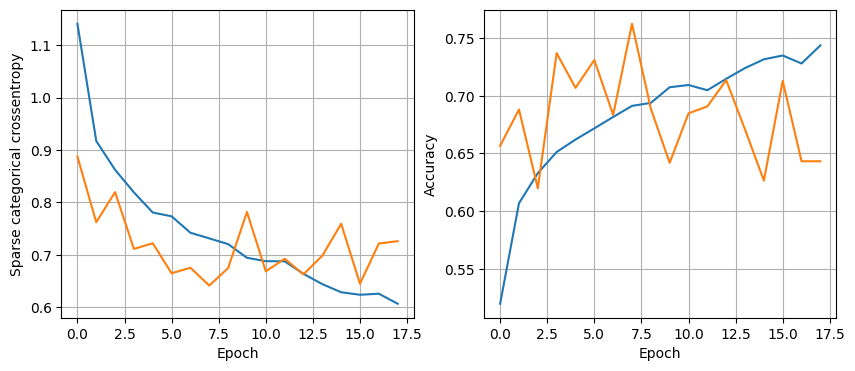

339/339 [==============================] - 1s 2ms/step

###### Training ######
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1204
           1       0.87      0.77      0.82      1204
           2       0.75      0.70      0.72      1204
           3       0.65      0.91      0.76      1204
           4       0.32      0.87      0.46      1204
           5       0.19      0.11      0.14      1204
           6       0.17      0.07      0.10      1204
           7       0.50      0.19      0.27      1204
           8       1.00      0.75      0.86      1204

    accuracy                           0.58     10836
   macro avg       0.60      0.58      0.56     10836
weighted avg       0.60      0.58      0.56     10836
47/47 [==============================] - 0s 2ms/step

###### Validation ######
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.95      

In [6]:
model, history, num_classes = tune_deep_fnn_model(
        df=df,
        epochs=1000,
        # Layers: 1, 2, 3, 4, 5, 6, 7
        layers=[2, 4],
        # Units: 8, 16, 32, 64, 96, 128, 160, 192
        units=[128, 256, 512],
        # Dropout rates: 0.2, 0.3, 0.4, 0.5
        dropout_rates=[0.2], 
        # Learning rates: # 0.0001, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002
        learning_rates=[0.001, 0.0015, 0.00175],   
        # Patience: 10, 20
        patience=[10, 20, 30],
        # Batch sizes: 10, 50, 100, 128, 150, 200, 250
        batch_sizes=[128]  
    )

# Least validation loss:
# 	Params:	 {Layers: 4; Units: 512; Dropout rate: 0.2; Learning rate: 0.0015; Patience: 10; Batch size: 128}
# 	Loss:	 0.5589165091514587
# 	Accuracy:	 0.7745163440704346

## Manual Tuning

In [ ]:
model, _, num_classes = train_deep_fnn_model(
                        df, 
                        epochs=2000, 
                        patience=5, 
                        layers=8, 
                        units=256,
                        dropout_rate=0.2,
                        learning_rate=0.001,
                        verbose=2,
                        batch_size=32,
                        disable_print_report=True)
print_results(model)

In [ ]:
y_pred = model.predict(x_test).argmax(axis=1)

result = test_df 
result["predicted_country_risk"] = y_pred

distribution = result.groupby(["country_risk", "predicted_country_risk"]).size().reset_index().rename(columns={0: 'count'})
distribution["difference"] = distribution["country_risk"] - distribution["predicted_country_risk"]
print(distribution)

In [ ]:
plt.bar(distribution["difference"], distribution["count"])
plt.xlabel("difference")
plt.ylabel("count")
plt.show()

### 2.4 Shap

In [ ]:
def shapify(data: pd.DataFrame):
    train, valid, test = split_data(data)

    train, x_train, train_labels = scale_dataset(train, oversample=True)
    valid, x_val, val_labels = scale_dataset(valid, oversample=False)
    test, x_test, test_labels = scale_dataset(test, oversample=False)
    
    explainer = shap.KernelExplainer(model.predict, x_train)
    shap_values = explainer.shap_values(x_test, nsamples=100) # nsamples { default = 2 * X.shape[1] + 2048 = 2066 }
    # explainer.save()
    
    return explainer, shap_values, x_test

In [ ]:
explainer, shap_values, shap_x_test = shapify(df[:1000])
from configs.enums import RISKCLASSIFICATIONS
shap.summary_plot(shap_values, shap_x_test, feature_names=df.columns[Column.COUNTRY_RISK], class_names=RISKCLASSIFICATIONS.get_names())